In [1]:
from __future__ import division
%matplotlib inline

In [2]:
import qinfer as qi

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot')
except:
    pass

## Uniform Sampling ##

Let's start by making some fake data from a precession experiment (e.g.: Rabi, Ramsey or phase estimation).

In [5]:
true_omega = 70.3
omega_min, omega_max = [10.3, 99.1]
n_shots = 400

ts = np.pi * (1 + np.arange(100)) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

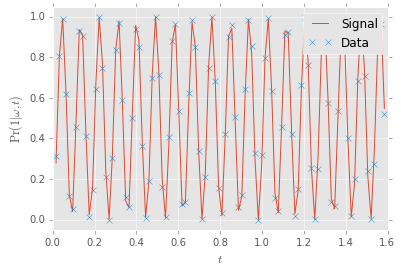

In [6]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

In [7]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [8]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{:0.3}s elapsed. Error: {:0.2e}".format(timing.delta_t, abs(mean - true_omega) / true_omega))

0.223s elapsed. Error: 8.52e-05


(0.0, 90.0)

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


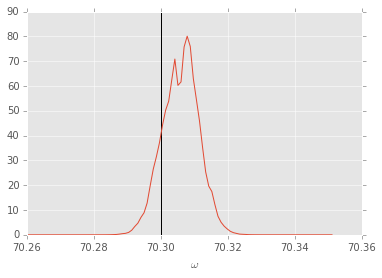

In [9]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)

## Exponentially-Sparse Sampling ##

In [10]:
true_omega = 70.3
omega_min, omega_max = [10.3, 99.1]
n_shots = 400

ts = np.pi * 1.125 ** (1 + np.arange(100)) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

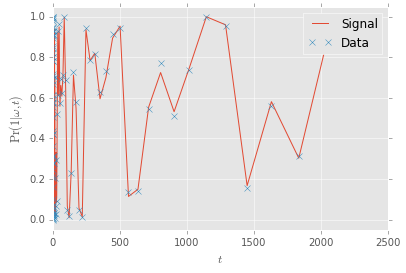

In [11]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

In [12]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [13]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{:0.3}s elapsed. Error: {:0.2e}".format(timing.delta_t, abs(mean - true_omega) / true_omega))

0.403s elapsed. Error: 4.34e-08


(0.0, 45000.0)

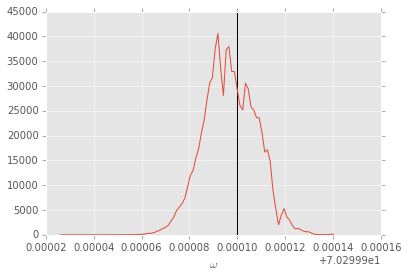

In [14]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)

## One-Bit Sampling ##

In [15]:
true_omega = 70.3
omega_min, omega_max = [10.3, 99.1]
n_shots = 1

t_min = np.pi / 2
t_max = 100000
ts = np.logspace(np.log10(t_min), np.log10(t_max), 1000) / (2 * omega_max)

signal = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n=n_shots, p=signal)

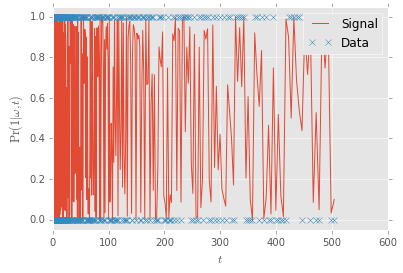

In [16]:
plt.plot(ts, signal, label='Signal')
plt.plot(ts, counts / n_shots, 'x', label='Data')
plt.xlabel('$t$')
plt.ylabel(r'$\Pr(1 | \omega, t)$')
plt.ylim(-0.05, 1.05)
plt.legend()

In [17]:
data = np.column_stack([counts, ts, n_shots * np.ones_like(counts)])

In [18]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(data, freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{:0.3}s elapsed. Error: {:0.2e}".format(timing.delta_t, abs(mean - true_omega) / true_omega))

1.82s elapsed. Error: 5.21e-06


(0.0, 1800.0)

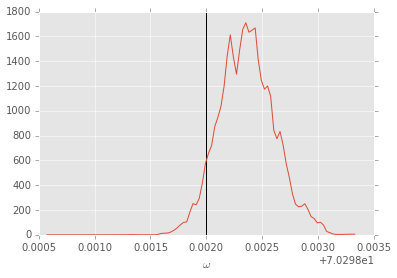

In [19]:
extra['updater'].plot_posterior_marginal()
ylim = plt.ylim()
plt.vlines(true_omega, *ylim)
plt.ylim(*ylim)

## Using Pandas DataFrames ##

In [20]:
import pandas as pd

In [21]:
dataframe = pd.DataFrame(data, columns=['counts', 't', 'n_shots'])
dataframe

,counts,t,n_shots
0,0.0,0.007925,1.0
1,1.0,0.008014,1.0
2,0.0,0.008103,1.0
3,0.0,0.008193,1.0
4,0.0,0.008284,1.0
5,0.0,0.008376,1.0
6,0.0,0.008470,1.0
7,0.0,0.008564,1.0
8,0.0,0.008659,1.0
9,0.0,0.008756,1.0


In [22]:
with qi.timing() as timing:
    mean, cov, extra = qi.simple_est_prec(dataframe
                                          , freq_min=omega_min, freq_max=omega_max, return_all=True)
print("{:0.3}s elapsed. Error: {:0.2e}".format(timing.delta_t, abs(mean - true_omega) / true_omega))

2.1s elapsed. Error: 5.38e-06
